In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

## 0.Load Data

In [2]:
# load EMG data for Subject #2
EMG_file_name='s2/S2_A1_E1.mat'
emg_data = loadmat(EMG_file_name)

print(f"What kind of data structure are we working with? {type(emg_data)}")
print(f"What are the keys of the data structure? {[key for key in emg_data.keys()]}")

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']


In [3]:
emg= emg_data["emg"].copy()
stimulus = emg_data["restimulus"] 
repetition = emg_data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


## 1. Preprocessing

### 1.1 Apply bandpass filter
Before preprocessing, we visualize the rawdata for subject2.

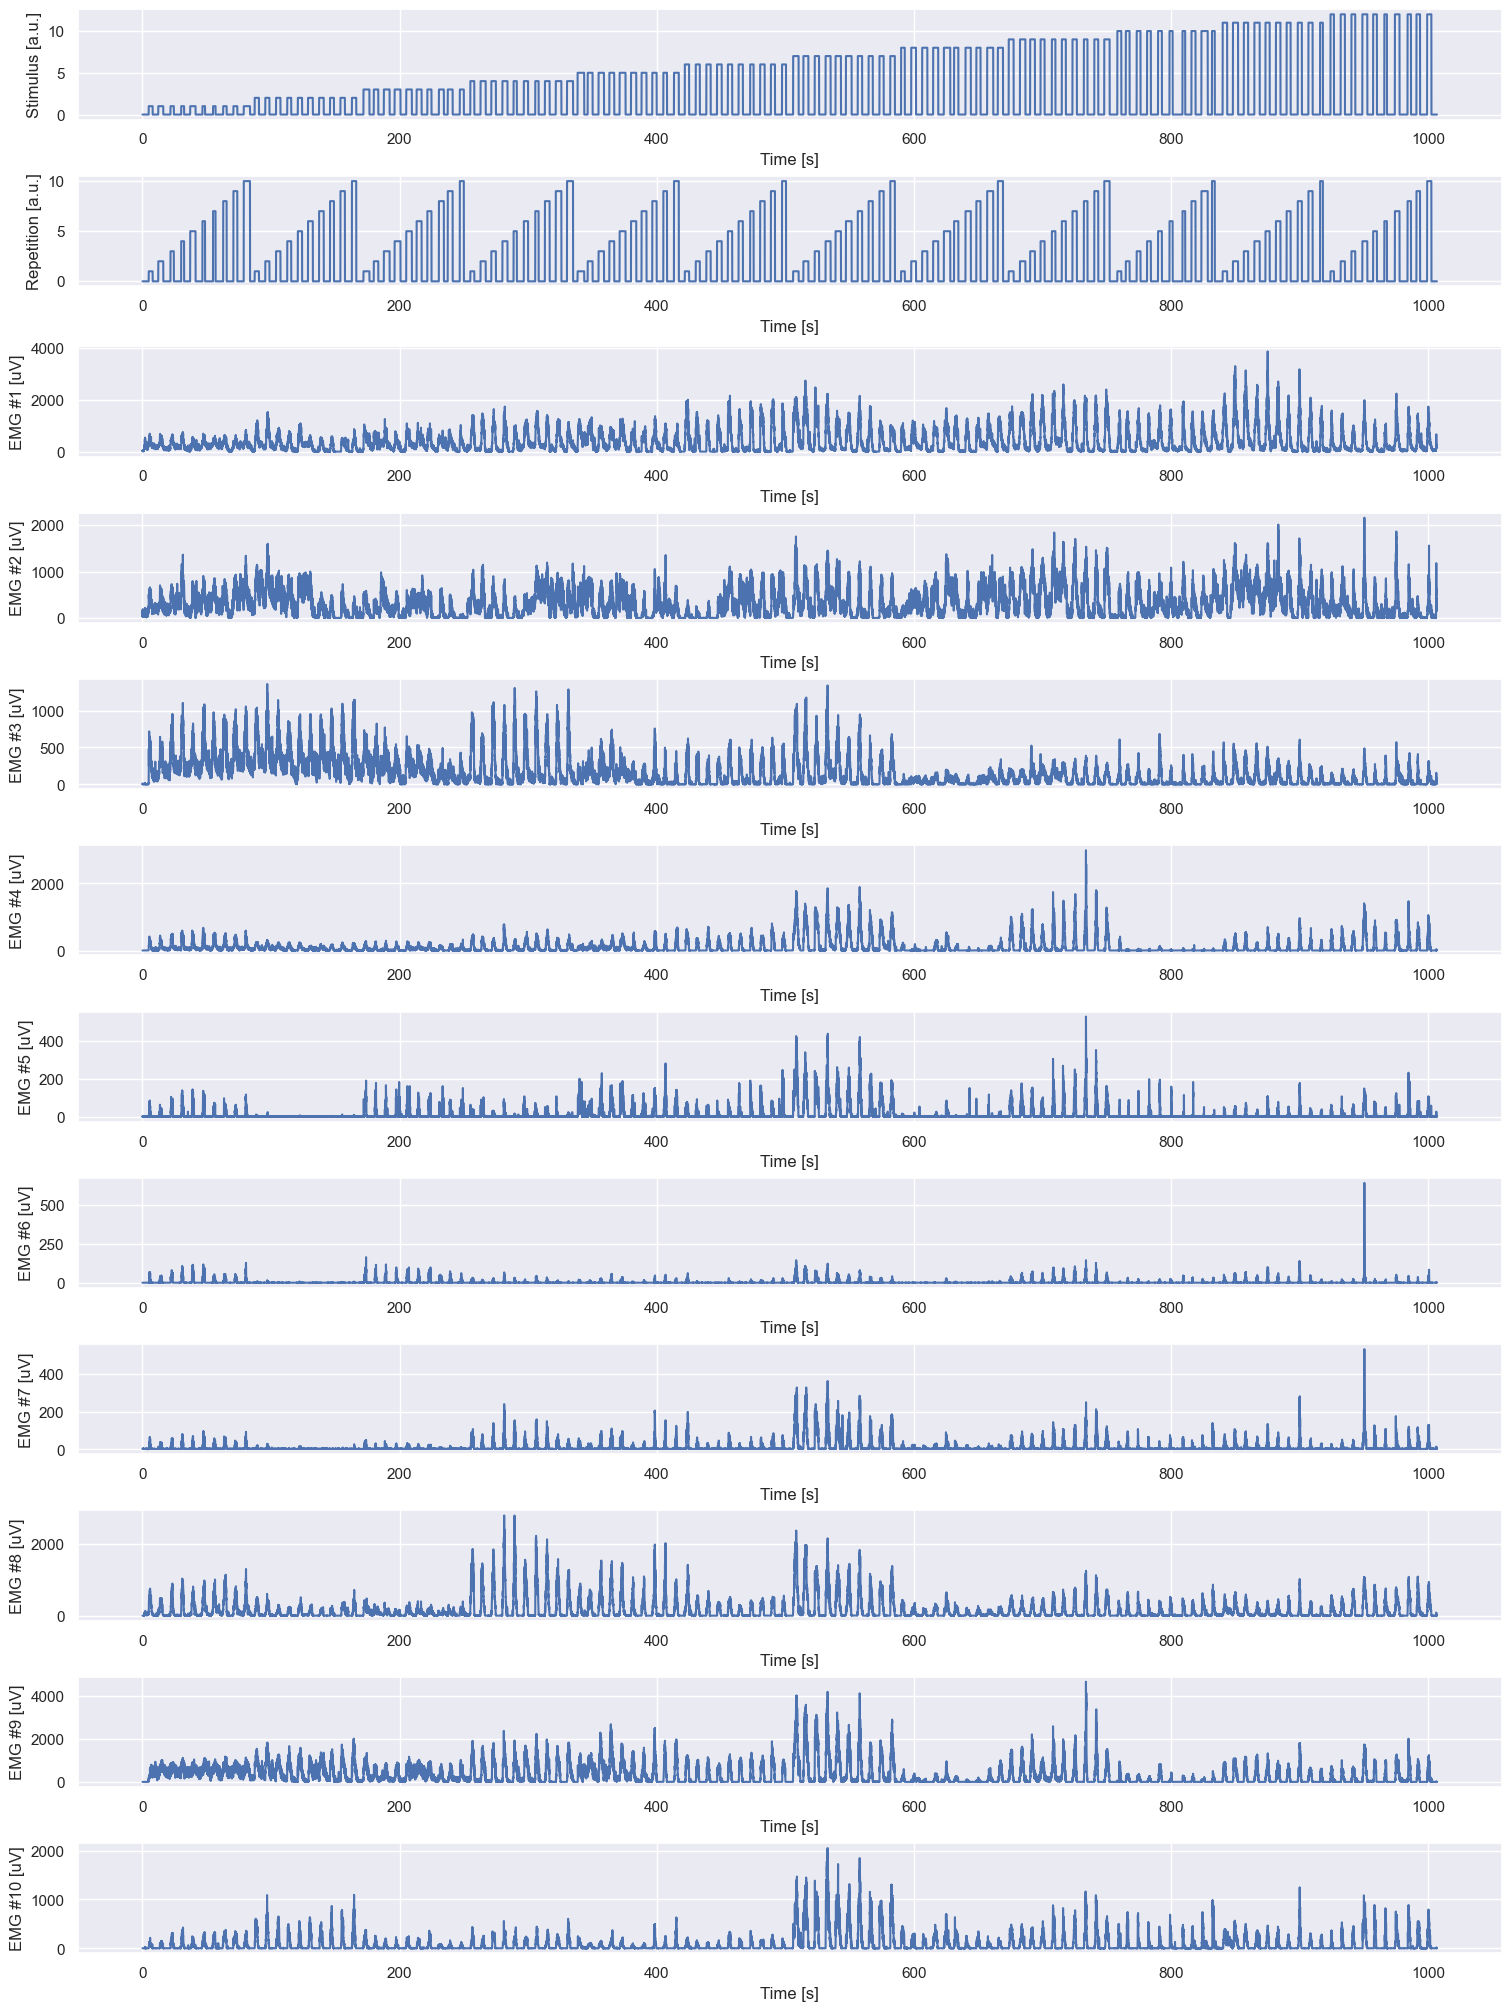

In [4]:
n_channels = emg.shape[1]

fs = 100 # According to the references, sampling frequency here is 2000 Hz.

time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

fig, ax = plt.subplots(n_channels+2, 1, constrained_layout=True, figsize=(15, 20))

ax[0].plot(time_steps, stimulus)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Stimulus [a.u.]")

ax[1].plot(time_steps, repetition)
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Repetition [a.u.]")

for channel_idx in range(n_channels):
    ax[channel_idx+2].plot(time_steps, emg[:, channel_idx]*1000)
    ax[channel_idx+2].set_xlabel("Time [s]")
    ax[channel_idx+2].set_ylabel(f"EMG #{channel_idx+1} [uV]")

Because the sEMG data was gathered using OttoBock MyoBock 13E200 surface EMG electrodes3, it is supposed to be amplified, bandpass-filtered and rectified version of the raw sEMG signal.

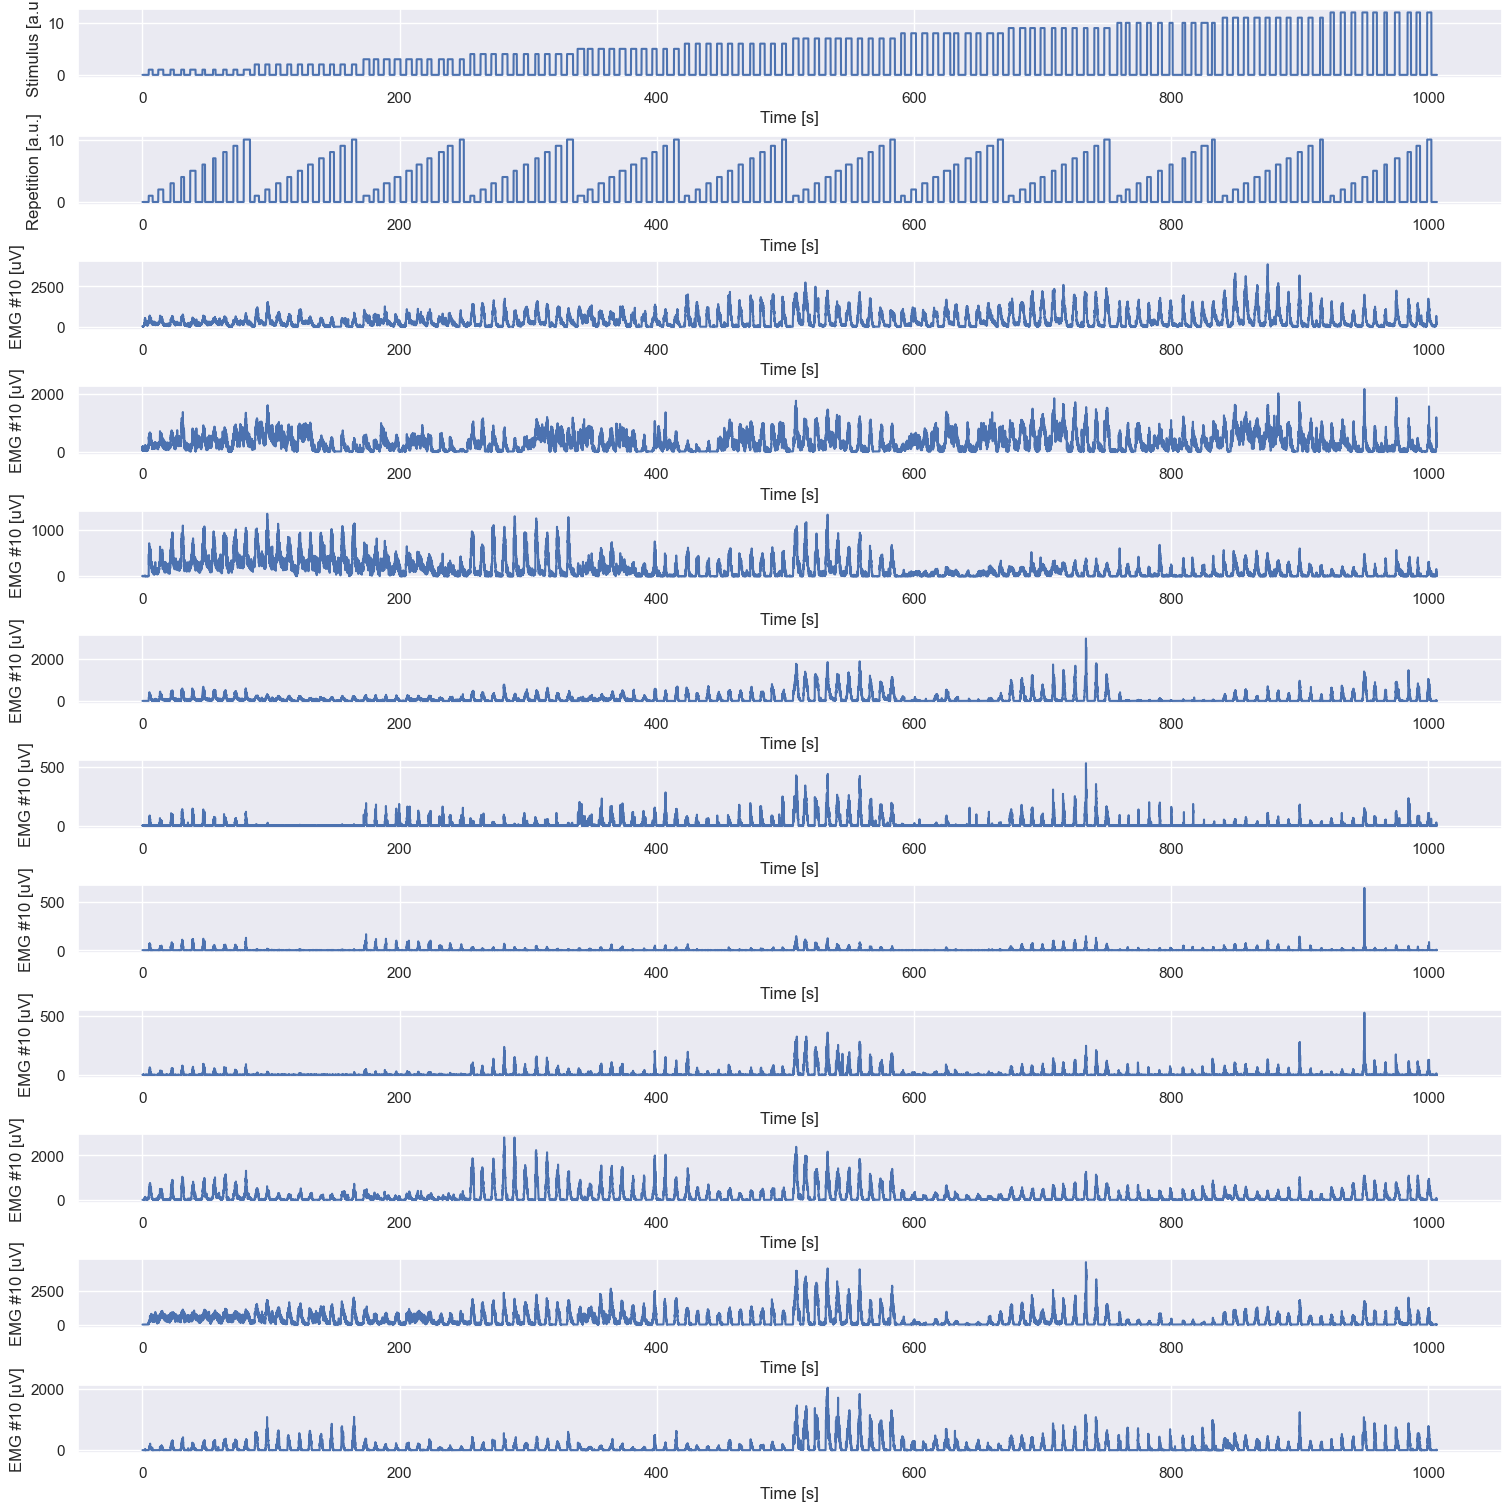

In [5]:
"""bandpass_cutoff_frequencies_Hz = (15, 100) 
sos = butter(N=0, Wn=15, fs=fs, btype="highpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 

powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics

for noise_frequency in powergrid_noise_frequencies_Hz:
    sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T"""

fs = 100  # Sampling frequency in Hz
low_cutoff_frequency = 5  # Highpass filter cutoff frequency in Hz

# Step 1: Highpass filter to remove low-frequency waves
sos_highpass = butter(N=0, Wn=low_cutoff_frequency, fs=fs, btype="highpass", output="sos")
emg_filtered = sosfiltfilt(sos_highpass, emg.T).T  # Apply highpass filter

# Step 2: Bandstop filters to remove 50 Hz and its harmonics
powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)]  # Add harmonics if needed, e.g., [50, 100]

for noise_frequency in powergrid_noise_frequencies_Hz:
    if noise_frequency < fs / 2:  # Ensure frequency is below Nyquist frequency
        sos_bandstop = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), 
                              fs=fs, btype="bandstop", output="sos")
        emg_filtered = sosfiltfilt(sos_bandstop, emg_filtered.T).T

fig, ax = plt.subplots(n_channels+2, 1, constrained_layout=True, figsize=(15, 15))
ax[0].plot(time_steps, stimulus)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Stimulus [a.u.]")

ax[1].plot(time_steps, repetition)
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Repetition [a.u.]")
for i in range(n_channels):
    ax[i+2].plot(time_steps, emg_filtered[:, i]*1000)
    ax[i+2].set_xlabel("Time [s]")
    ax[i+2].set_ylabel(f"EMG #{channel_idx+1} [uV]")

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

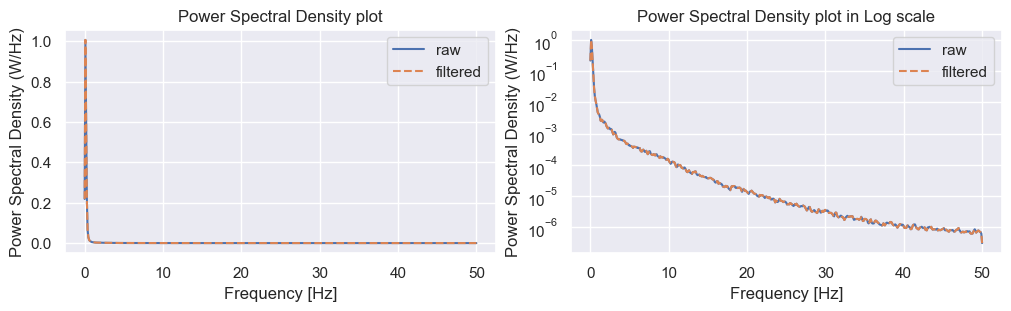

In [6]:
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

In [7]:
# -1 because 0 is not meaningful
n_stimuli = len(np.unique(stimulus)) - 1
n_repetitions = len(np.unique(repetition)) - 1
n_channels = emg_filtered.shape[1]

print(f'How many types of movement are there? {n_stimuli}')
print(f'How many repetitions are there? {n_repetitions}')
print(f'How many channels are there? {n_channels}')

How many types of movement are there? 12
How many repetitions are there? 10
How many channels are there? 10


In [8]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):

        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

### 1.2 Compute the envelop of the signal

In [ ]:
mov_mean_size = 200
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_filtered[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

Text(0.5, 0.98, 'Envelopes of the EMG signal (Example from Movement 1, Repetition 1)')

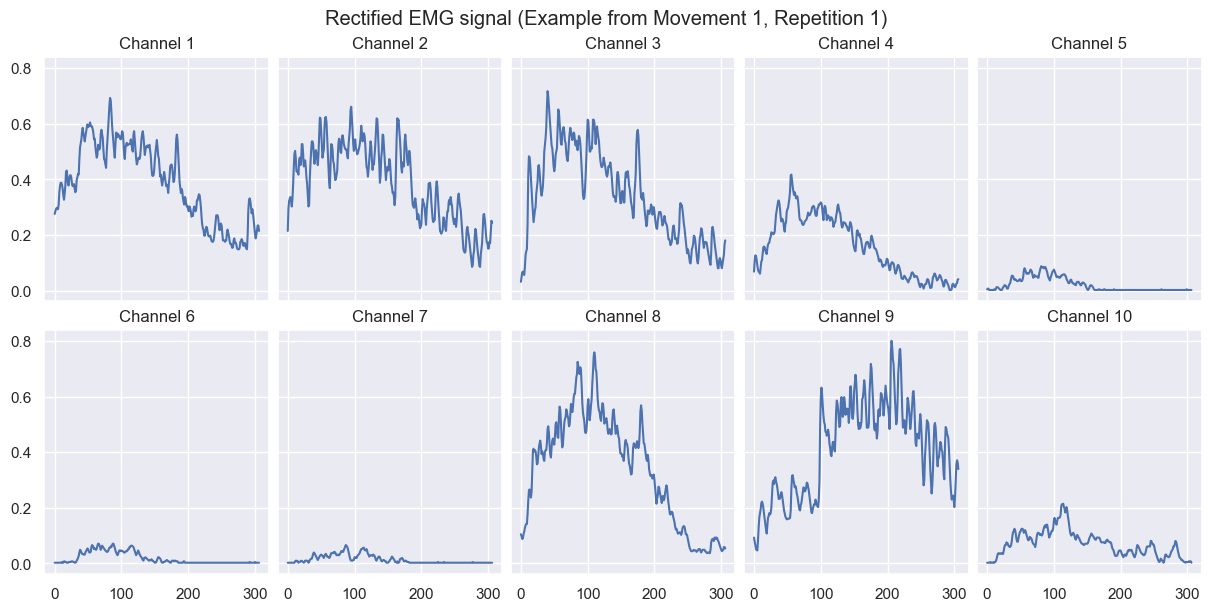

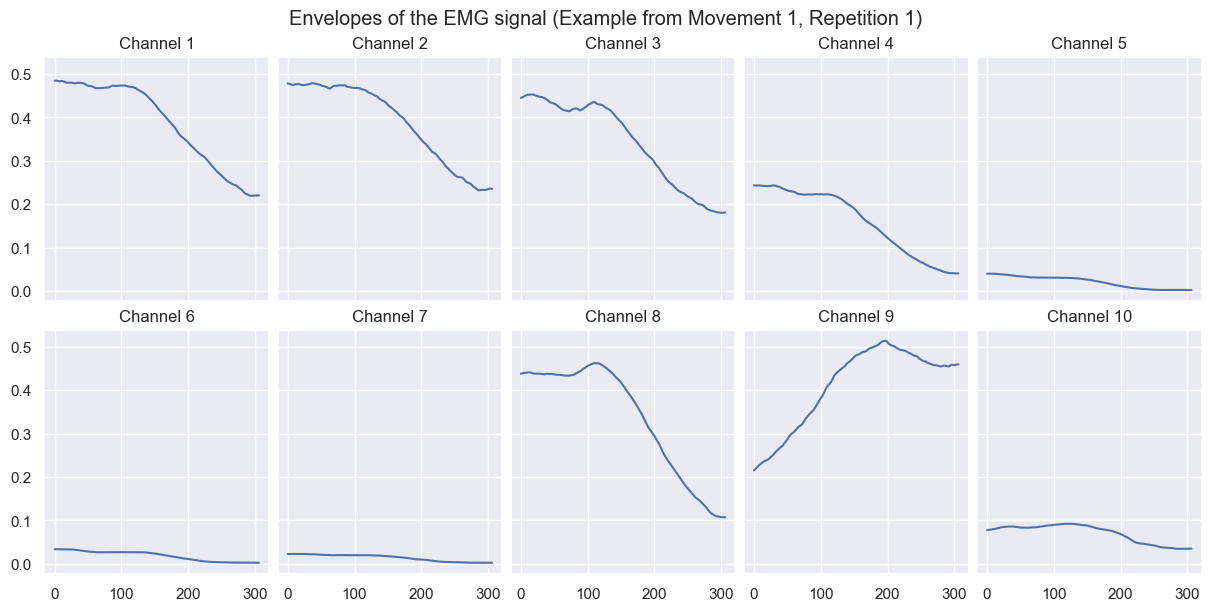

In [10]:
# Plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_filtered.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal (Example from Movement 1, Repetition 1)")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal (Example from Movement 1, Repetition 1)")

### 1.3 Visualizing across repetitions

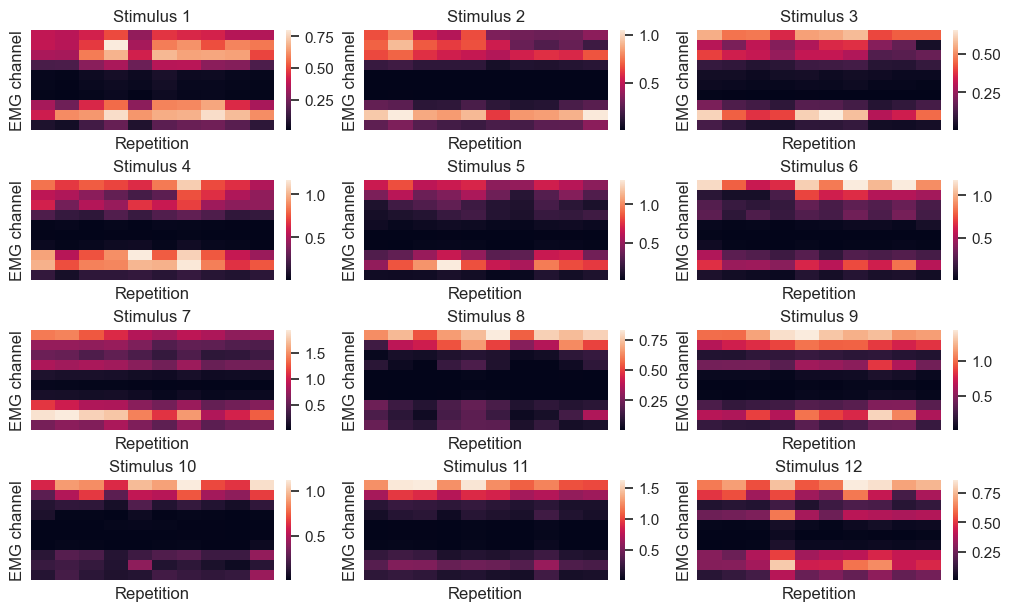

In [11]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)

fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

### 1.3. Extract features from the trials (at least 5 different ones).

In [12]:
def build_dataset_from_ninapro(_emg, _stimulus, _repetition, features=None, feature_norm=False):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    _n_stimuli = len(np.unique(_stimulus)) - 1
    _n_repetitions = len(np.unique(_repetition)) - 1
    # Total number of samples is the product of stimuli and repetitions
    _n_samples = _n_stimuli * _n_repetitions

    # Number of channels in the EMG data
    _n_channels = _emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(_n_channels for feature in features)

    # Initialize the dataset and labels arrays with zeros
    _dataset = np.zeros((_n_samples, n_features))
    _labels = np.zeros(_n_samples)
    current_sample_index = 0

    # Loop over each stimulus and repetition to extract features
    for i in range(_n_stimuli):
        for j in range(_n_repetitions):
            # Assign the label for the current sample
            _labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * _n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(_stimulus == i + 1, _repetition == j + 1).squeeze()

            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + _n_channels)
                # Apply the feature function to the selected EMG data and store the result
                cur_feature = feature(_emg[selected_tsteps, :])
                _dataset[current_sample_index, selected_features] = cur_feature
                # Update the feature index for the next feature
                current_feature_index += _n_channels

            # Move to the next sample
            current_sample_index += 1
    if feature_norm:
        _dataset = (_dataset - _dataset.min(axis=0)) / (_dataset.max(axis=0) - _dataset.min(axis=0))

    # Return the constructed dataset and corresponding labels
    return _dataset, _labels

dataset dimension: (120, 70)
labels dimension: (120,)


C:\Users\pengh\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 226, using nperseg = 226
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
C:\Users\pengh\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 204, using nperseg = 204
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
C:\Users\pengh\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 196, using nperseg = 196
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
C:\Users\pengh\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 255, using nperseg = 255
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
C:\Users\pengh\anaconda3\Lib\site-packages\scipy\signal\_spectral_py

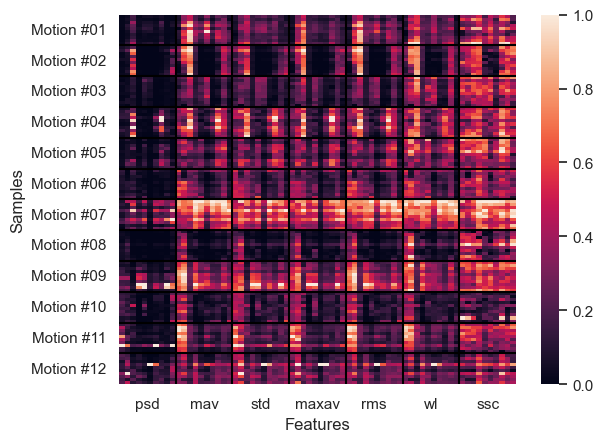

In [13]:
# Define the features

# Power Spectral Density (PSD)
from scipy.signal import welch
psd = lambda x: np.sum(welch(x, axis=0)[1], axis=0)
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)


dataset, labels = build_dataset_from_ninapro(
    _emg=emg_filtered,
    _stimulus=stimulus,
    _repetition=repetition,
        features=[psd, mav, std, maxav, rms, wl, ssc],
    feature_norm=True
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")
sns.heatmap(dataset)
plt.xlabel('Features')
plt.ylabel('Samples')
plt.yticks(range(5, 116, 10), [f'Motion #%02d' % (x+1) for x in range(12)])
plt.xticks(range(5, 66, 10), ['psd', 'mav', 'std', 'maxav', 'rms', 'wl', 'ssc'])

ax = plt.gca()
for x in range(10, dataset.shape[1], 10):  # every 10 features
    ax.axvline(x=x, color='black', linestyle='-', linewidth=1.5)
for y in range(10, dataset.shape[0], 10):  # every 10 samples
    ax.axhline(y=y, color='black', linestyle='-', linewidth=1.5)


### 1.4. Perform classification on the data of subject 2 - Gradient Boost Decision Tree

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Train:Validation:Test=70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(dataset, labels, test_size=0.3, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'n_training: {X_train.shape[0]}, n_validation: {X_val.shape[0]}, n_test: {X_test.shape[0]}')

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)
X_test_z = scaler.transform(X_test)

n_training: 84, n_validation: 18, n_test: 18


n_training: 84, n_validation: 18, n_test: 18
Accuracy score: 0.7777777777777778


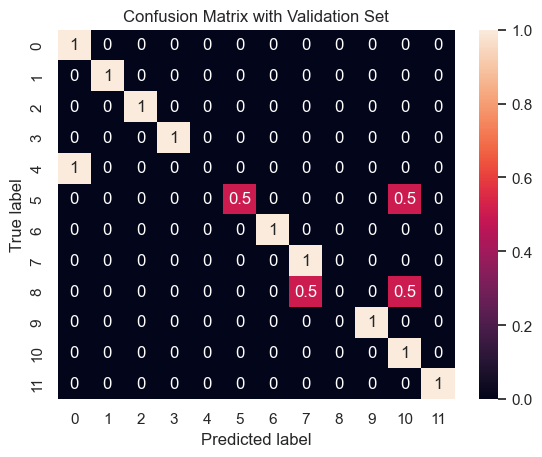

In [15]:
# Classifier
clf = GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.1, min_samples_leaf=4,min_samples_split=2,random_state=42)
clf.fit(X_train_z, y_train)

# Predict in validation
y_pred = clf.predict(X_val_z)

# Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion Matrix
confmat = confusion_matrix(y_val, y_pred, normalize="true")
fig, ax = plt.subplots()

sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix with Validation Set")
plt.show()

Accuracy score: 0.8333333333333334


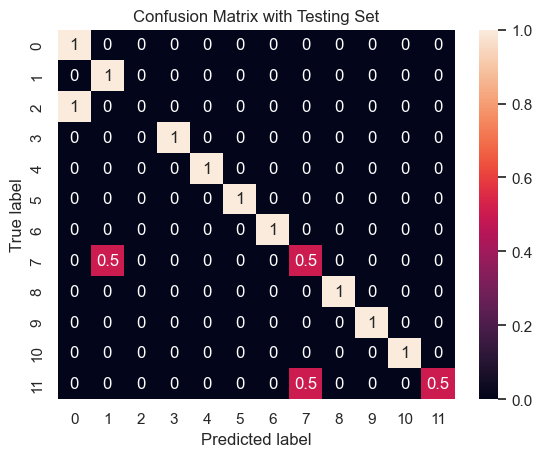

In [16]:
# Predict in test
y_pred = clf.predict(X_test_z)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion Matrix
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()

sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix with Testing Set")
plt.show()

In [17]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, dataset, labels, cv=5)
print(f"Cross Validation Accuracy: {scores}, Mean={np.mean(scores)}")

Cross Validation Accuracy: [0.70833333 0.83333333 1.         0.875      0.83333333], Mean=0.85


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy: 0.799264705882353
Test Accuracy after Optimization: 0.8333333333333334


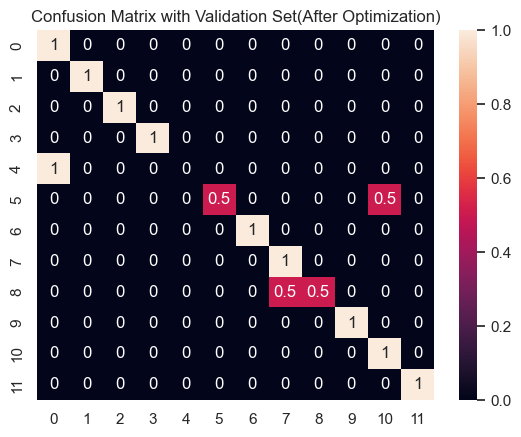

In [29]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter search space
param_grid = {
    "n_estimators": [100,200,300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
}

# Instantiation model
clf = GradientBoostingClassifier(random_state=42)

# grid search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_z, y_train)

# Output optimum parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate the validation set with the best parameters
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_val_z)

# Recalculate the accuracy and confusion matrix
accuracy = accuracy_score(y_val, y_pred)
print(f"Test Accuracy after Optimization: {accuracy}")

confmat = confusion_matrix(y_val, y_pred, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix with Validation Set(After Optimization)")
plt.show()

Test Accuracy after Optimization: 0.8333333333333334


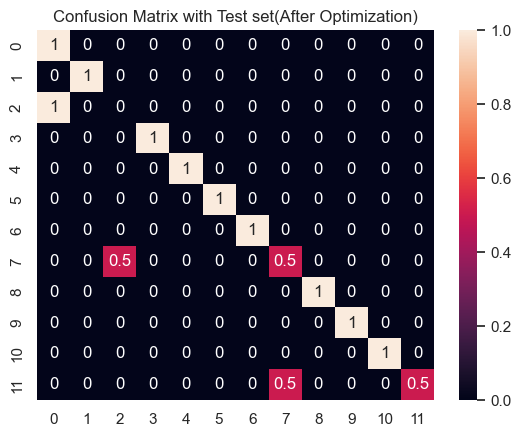

In [30]:
# Evaluate the test set with the best parameters
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_z)

# Recalculate the accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy after Optimization: {accuracy}")

confmat = confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix with Test set(After Optimization)")
plt.show()

## 1.6.1 Feature Selection

Estimated mutual information between each feature and the target:
 [0.63632765 0.40985103 0.62442678 0.78320575 0.57055625 0.56338939
 0.52469963 0.59230785 0.75211893 0.57688829 0.67298558 0.28703973
 0.7756326  0.81795809 0.80860402 0.59218862 0.62570874 0.6974594
 0.78345774 0.71166685 0.81810023 0.32680754 0.75610156 0.83299981
 0.7656365  0.60556611 0.67842165 0.79309291 0.875026   0.74228521
 0.80849614 0.40116207 0.60478026 0.83635477 0.6465336  0.57554287
 0.5617072  0.69399904 0.76485282 0.72629902 0.72358623 0.32521683
 0.76358616 0.83255105 0.75735164 0.62285116 0.64482704 0.68493799
 0.79753052 0.72756872 0.50563811 0.14982436 0.81402785 0.98317794
 0.89672632 0.76532271 0.59469704 0.69111115 0.80859741 0.75182407
 0.13107508 0.09536784 0.2195801  0.33801092 0.82768223 0.50902781
 0.46493703 0.21426216 0.38316553 0.23270941]



  2%|▏         | 1/60 [00:02<02:45,  2.80s/it]

Accuracy score of a model with 1 best features: 0.3333333333333333


  3%|▎         | 2/60 [00:05<02:38,  2.74s/it]

Accuracy score of a model with 2 best features: 0.5


  5%|▌         | 3/60 [00:08<02:42,  2.85s/it]

Accuracy score of a model with 3 best features: 0.6666666666666666


  7%|▋         | 4/60 [00:11<02:35,  2.78s/it]

Accuracy score of a model with 4 best features: 0.6666666666666666


  8%|▊         | 5/60 [00:13<02:31,  2.76s/it]

Accuracy score of a model with 5 best features: 0.5555555555555556


 10%|█         | 6/60 [00:16<02:29,  2.76s/it]

Accuracy score of a model with 6 best features: 0.6111111111111112


 12%|█▏        | 7/60 [00:19<02:30,  2.84s/it]

Accuracy score of a model with 7 best features: 0.6111111111111112


 13%|█▎        | 8/60 [00:22<02:29,  2.87s/it]

Accuracy score of a model with 8 best features: 0.6111111111111112


 15%|█▌        | 9/60 [00:25<02:31,  2.97s/it]

Accuracy score of a model with 9 best features: 0.6666666666666666


 17%|█▋        | 10/60 [00:28<02:31,  3.03s/it]

Accuracy score of a model with 10 best features: 0.7777777777777778


 18%|█▊        | 11/60 [00:32<02:31,  3.10s/it]

Accuracy score of a model with 11 best features: 0.6666666666666666


 20%|██        | 12/60 [00:35<02:27,  3.07s/it]

Accuracy score of a model with 12 best features: 0.8333333333333334


 22%|██▏       | 13/60 [00:38<02:24,  3.07s/it]

Accuracy score of a model with 13 best features: 0.7777777777777778


 23%|██▎       | 14/60 [00:41<02:21,  3.07s/it]

Accuracy score of a model with 14 best features: 0.7222222222222222


 25%|██▌       | 15/60 [00:44<02:18,  3.09s/it]

Accuracy score of a model with 15 best features: 0.7222222222222222


 27%|██▋       | 16/60 [00:47<02:15,  3.08s/it]

Accuracy score of a model with 16 best features: 0.7222222222222222


 28%|██▊       | 17/60 [00:50<02:12,  3.09s/it]

Accuracy score of a model with 17 best features: 0.7777777777777778


 30%|███       | 18/60 [00:53<02:10,  3.12s/it]

Accuracy score of a model with 18 best features: 0.7222222222222222


 32%|███▏      | 19/60 [00:56<02:08,  3.14s/it]

Accuracy score of a model with 19 best features: 0.8333333333333334


 33%|███▎      | 20/60 [01:00<02:06,  3.17s/it]

Accuracy score of a model with 20 best features: 0.7777777777777778


 35%|███▌      | 21/60 [01:03<02:04,  3.20s/it]

Accuracy score of a model with 21 best features: 0.7777777777777778


 37%|███▋      | 22/60 [01:06<02:02,  3.22s/it]

Accuracy score of a model with 22 best features: 0.8888888888888888


 38%|███▊      | 23/60 [01:10<02:00,  3.26s/it]

Accuracy score of a model with 23 best features: 0.7777777777777778


 40%|████      | 24/60 [01:13<01:58,  3.29s/it]

Accuracy score of a model with 24 best features: 0.7777777777777778


 42%|████▏     | 25/60 [01:16<01:57,  3.34s/it]

Accuracy score of a model with 25 best features: 0.8333333333333334


 43%|████▎     | 26/60 [01:20<01:54,  3.37s/it]

Accuracy score of a model with 26 best features: 0.8333333333333334


 45%|████▌     | 27/60 [01:23<01:52,  3.40s/it]

Accuracy score of a model with 27 best features: 0.7777777777777778


 47%|████▋     | 28/60 [01:27<01:50,  3.47s/it]

Accuracy score of a model with 28 best features: 0.7222222222222222


 48%|████▊     | 29/60 [01:31<01:50,  3.55s/it]

Accuracy score of a model with 29 best features: 0.7777777777777778


 50%|█████     | 30/60 [01:34<01:47,  3.58s/it]

Accuracy score of a model with 30 best features: 0.7222222222222222


 52%|█████▏    | 31/60 [01:38<01:45,  3.64s/it]

Accuracy score of a model with 31 best features: 0.7222222222222222


 53%|█████▎    | 32/60 [01:42<01:43,  3.69s/it]

Accuracy score of a model with 32 best features: 0.7777777777777778


 55%|█████▌    | 33/60 [01:46<01:39,  3.68s/it]

Accuracy score of a model with 33 best features: 0.7777777777777778


 57%|█████▋    | 34/60 [01:49<01:35,  3.69s/it]

Accuracy score of a model with 34 best features: 0.7777777777777778


 58%|█████▊    | 35/60 [01:53<01:32,  3.71s/it]

Accuracy score of a model with 35 best features: 0.7222222222222222


 60%|██████    | 36/60 [01:57<01:30,  3.78s/it]

Accuracy score of a model with 36 best features: 0.7222222222222222


 62%|██████▏   | 37/60 [02:01<01:27,  3.81s/it]

Accuracy score of a model with 37 best features: 0.7777777777777778


 63%|██████▎   | 38/60 [02:05<01:24,  3.84s/it]

Accuracy score of a model with 38 best features: 0.7777777777777778


 65%|██████▌   | 39/60 [02:09<01:20,  3.85s/it]

Accuracy score of a model with 39 best features: 0.7777777777777778


 67%|██████▋   | 40/60 [02:13<01:17,  3.88s/it]

Accuracy score of a model with 40 best features: 0.7777777777777778


 68%|██████▊   | 41/60 [02:17<01:14,  3.90s/it]

Accuracy score of a model with 41 best features: 0.7777777777777778


 70%|███████   | 42/60 [02:21<01:10,  3.94s/it]

Accuracy score of a model with 42 best features: 0.7777777777777778


 72%|███████▏  | 43/60 [02:25<01:07,  3.97s/it]

Accuracy score of a model with 43 best features: 0.7777777777777778


 73%|███████▎  | 44/60 [02:29<01:03,  4.00s/it]

Accuracy score of a model with 44 best features: 0.7222222222222222


 75%|███████▌  | 45/60 [02:33<01:00,  4.02s/it]

Accuracy score of a model with 45 best features: 0.7777777777777778


 77%|███████▋  | 46/60 [02:37<00:57,  4.08s/it]

Accuracy score of a model with 46 best features: 0.7777777777777778


 78%|███████▊  | 47/60 [02:41<00:53,  4.10s/it]

Accuracy score of a model with 47 best features: 0.7777777777777778


 80%|████████  | 48/60 [02:46<00:51,  4.27s/it]

Accuracy score of a model with 48 best features: 0.7222222222222222


 82%|████████▏ | 49/60 [02:50<00:47,  4.35s/it]

Accuracy score of a model with 49 best features: 0.7222222222222222


 83%|████████▎ | 50/60 [02:55<00:43,  4.33s/it]

Accuracy score of a model with 50 best features: 0.7777777777777778


 85%|████████▌ | 51/60 [02:59<00:39,  4.34s/it]

Accuracy score of a model with 51 best features: 0.7222222222222222


 87%|████████▋ | 52/60 [03:03<00:34,  4.36s/it]

Accuracy score of a model with 52 best features: 0.7222222222222222


 88%|████████▊ | 53/60 [03:08<00:30,  4.35s/it]

Accuracy score of a model with 53 best features: 0.7222222222222222


 90%|█████████ | 54/60 [03:12<00:25,  4.33s/it]

Accuracy score of a model with 54 best features: 0.6666666666666666


 92%|█████████▏| 55/60 [03:16<00:21,  4.36s/it]

Accuracy score of a model with 55 best features: 0.6666666666666666


 93%|█████████▎| 56/60 [03:21<00:17,  4.41s/it]

Accuracy score of a model with 56 best features: 0.7222222222222222


 95%|█████████▌| 57/60 [03:25<00:13,  4.38s/it]

Accuracy score of a model with 57 best features: 0.6666666666666666


 97%|█████████▋| 58/60 [03:30<00:08,  4.37s/it]

Accuracy score of a model with 58 best features: 0.7222222222222222


 98%|█████████▊| 59/60 [03:34<00:04,  4.43s/it]

Accuracy score of a model with 59 best features: 0.7222222222222222


100%|██████████| 60/60 [03:39<00:00,  3.66s/it]


Accuracy score of a model with 60 best features: 0.6666666666666666


ValueError: x and y must have same first dimension, but have shapes (26,) and (60,)

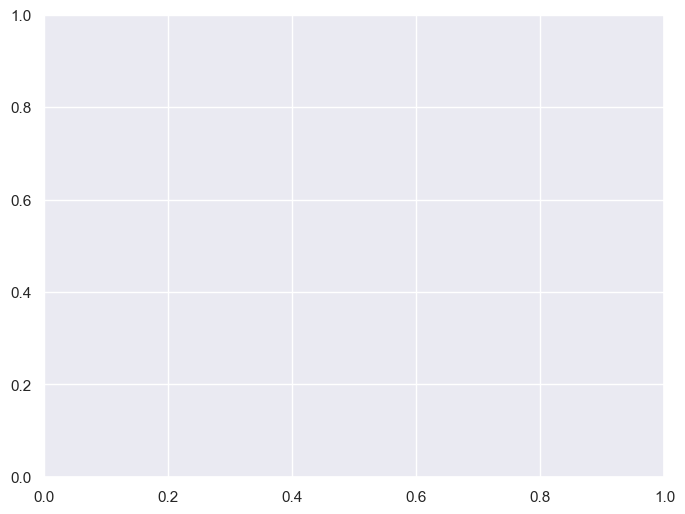

In [27]:
# Import necessary functions for feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from tqdm import tqdm

# Calculate mutual information between each feature and the target variable.
# Mutual information is a measure of the dependency between variables.
# A higher value indicates a stronger relationship.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

acc_list = []
for k_features in tqdm(range(1, 60+1)):
    # Select the top 30 features based on mutual information scores.
    # Note: You can change 'k' to 10 if you are working with fewer features.
    k_best = SelectKBest(mutual_info_classif, k=k_features)
    k_best.fit(X_train_z, y_train)

    # Transform the training and test datasets to only include the selected features.
    X_train_best = k_best.transform(X_train_z)
    X_test_best = k_best.transform(X_test_z)

    clf = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.01, random_state=42, min_samples_split=2, min_samples_leaf=4)
    clf.fit(X_train_best, y_train)

    # Predict the labels for the test set using the trained model.
    y_pred = clf.predict(X_test_best)

    # Calculate the accuracy of the model with the selected features.
    # Accuracy is the ratio of correctly predicted instances to the total instances.
    accuracy = accuracy_score(y_test, y_pred)
    tqdm.write(f"Accuracy score of a model with {k_features} best features: {accuracy}")
    acc_list.append(accuracy)

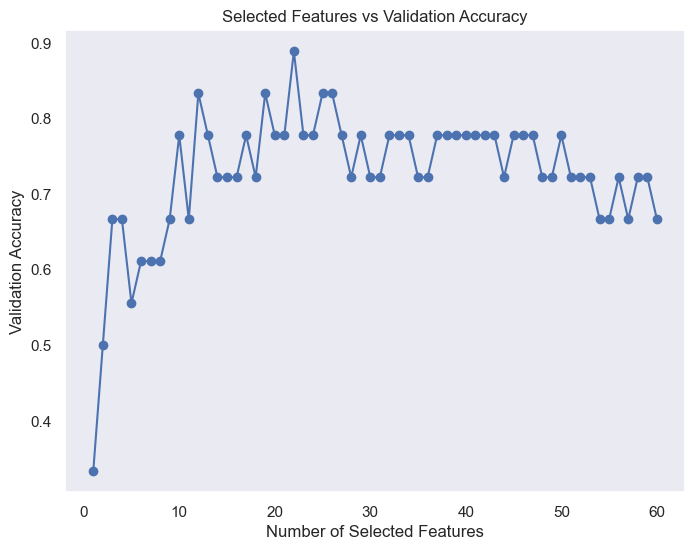

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 60+1), acc_list, marker='o')
plt.xlabel('Number of Selected Features')
plt.ylabel('Validation Accuracy')
plt.title('Selected Features vs Validation Accuracy')
plt.grid()
plt.show()

Accuracy score of a model with 30 best features: 0.7777777777777778


Text(47.25, 0.5, 'True label')

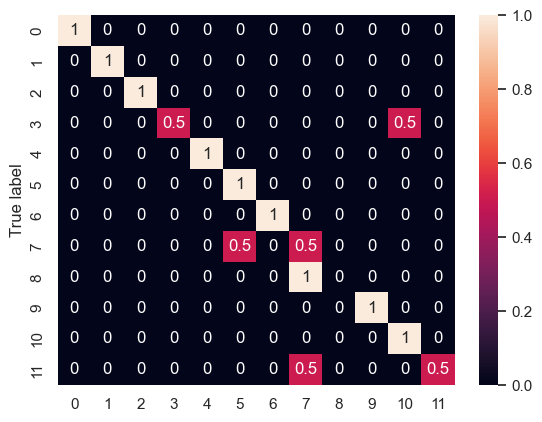

In [26]:
best_k = 24
k_best = SelectKBest(mutual_info_classif, k=best_k)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

clf = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.01, random_state=42, min_samples_split=2, min_samples_leaf=4)
clf.fit(X_train_best, y_train)

# Predict the labels for the test set using the trained model.
y_pred = clf.predict(X_test_best)

# Calculate the accuracy of the model with the selected features.
# Accuracy is the ratio of correctly predicted instances to the total instances.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of a model with {k_features} best features: {accuracy}")
acc_list.append(accuracy)

# Create a confusion matrix to visualize the performance of the classification model.
# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
# ax.set_xlabel("Predicted label")

## 1.6.2 Dimension Reduction

Best number of PCA components: 16
Best Validation Accuracy: 0.7222


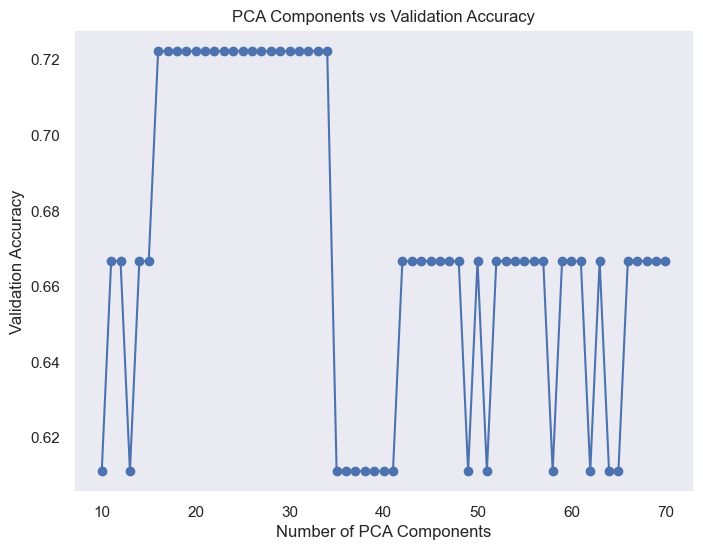

In [20]:
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

# automatically find the best number of PCA components
n_features = X_train_z.shape[1]  # total number of features
best_accuracy = 0
best_n_components = 0
accuracies = []

# test different number of components
for n_components in tqdm(range(10, n_features+1)):  # components from 10 to n_features (inclusive)
    pca = PCA(n_components=n_components)
    
    # Use PCA to reduce the number of features
    X_train_pca = pca.fit_transform(X_train_z)
    X_val_pca = pca.transform(X_val_z)
    
    # train the model
    clf_pca = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.01, random_state=42, min_samples_split=2, min_samples_leaf=4)
    clf_pca.fit(X_train_pca, y_train)
    
    # evaluate the performance
    y_pred_pca = clf_pca.predict(X_val_pca)
    accuracy_pca = accuracy_score(y_val, y_pred_pca)
    accuracies.append(accuracy_pca)
    
    # record the best number of components and accuracy
    if accuracy_pca > best_accuracy:
        best_accuracy = accuracy_pca
        best_n_components = n_components

# Best number of PCA components and accuracy
print(f"Best number of PCA components: {best_n_components}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Accuracy of visualization with different number of features

plt.figure(figsize=(8, 6))
plt.plot(range(10, n_features + 1), accuracies, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Validation Accuracy')
plt.title('PCA Components vs Validation Accuracy')
plt.grid()
plt.show()

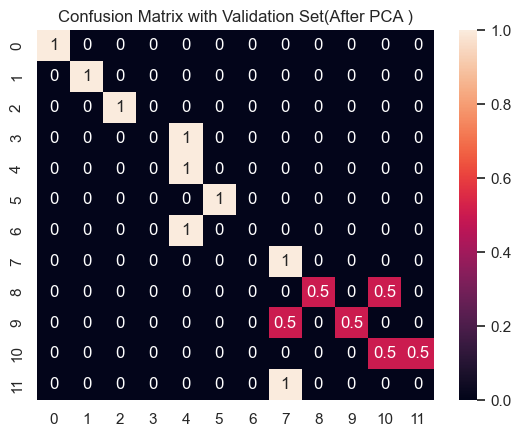

In [21]:
# validation set cofusion matrix with the best number of components 
confmat = confusion_matrix(y_val, y_pred_pca, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix with Validation Set(After PCA )")
plt.show()

Test Set Accuracy after PCA with 16 components: 0.7222222222222222


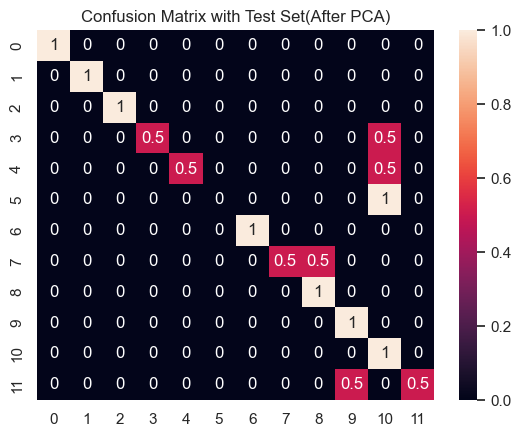

In [22]:
# Evaluate the test set with the best number of PCA components
n_components = 16  # best number of PCA components

# Use PCA to reduce the number of features
X_train_pca = pca.fit_transform(X_train_z)

# test set
X_test_pca = pca.transform(X_test_z)

# retrain the model
clf_pca = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.01, random_state=42)
clf_pca.fit(X_train_pca, y_train)

# predict the test set
y_pred_test_pca = clf_pca.predict(X_test_pca)

# evaluate the performance
accuracy_test_pca = accuracy_score(y_test, y_pred_test_pca)
print(f"Test Set Accuracy after PCA with {n_components} components: {accuracy_test_pca}")

confmat = confusion_matrix(y_test, y_pred_test_pca, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix with Test Set(After PCA)")
plt.show()